# MRCT Benchmark
In this jupyter notebook the mSTreg heuristic will compared against the Campos and GRASP_PR algorithms. The task is to approximate the Minimum Routing Cost Tree (MRCT), that is the Central Spanning Tree with $\alpha=1$

In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


In [2]:
import os
import sys
if 'Benchmark_OR' in os.getcwd():
	os.chdir('../../..')
	sys.path.insert(0,os.getcwd())
print(os.getcwd())
print(sys.path[0])

/export/home/enfita/Code/CST_official_github_repo
/export/home/enfita/Code/CST_official_github_repo


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

from lib.CST.T_datacls import T_data
from Experiments.Benchmark_mSTreg.Benchmark_OR.load_ORdata import load_ORdata_instance
from lib.CST.methods.MRCT.Campos import Campos_MRCT
from sklearn.metrics import pairwise_distances
import scipy.sparse as sp
import pandas as pd
from lib.CST.T_datacls.utilities.graphtools import Wiener_index
from tqdm import tqdm

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


/export/home/enfita/Code/CST_official_github_repo/lib/methods/mSTreg/topology/topology.py:74: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def vec_to_adj(vec):


Set parameters

In [4]:
save = False
maxiter_mSTreg=20
maxfreq_mSTreg=5

alpha_ls=np.linspace(0,1,11)
merging_criterium='tryall'
order_criterium='closest'
criterium_BP_position_update='median'

num_samples=[50,100,250]
num_problems = range(1, 8)

### Compute costs of the different algorithms

In [5]:

costs_mSTREG=np.zeros((len(num_problems),len(num_samples)))
costs_NOmSTREG=np.zeros((len(num_problems),len(num_samples)))
costs_campos=np.zeros((len(num_problems),len(num_samples)))
costs_star=np.zeros((len(num_problems),len(num_samples)))


pbar = tqdm(total=len(num_samples)*len(num_problems), desc="Processing", ncols=100)
for column,n in enumerate(num_samples):
    for row,problem_number in enumerate(num_problems):
        pbar.update(1)
        P=load_ORdata_instance(n,problem_number)


        alpha=1
        tdata=T_data(P,verbose=False)
        tdata.compute_BCST(alpha=alpha, maxiter_mSTreg=maxiter_mSTreg,
                             maxfreq_mSTreg=maxfreq_mSTreg,order_criterium = order_criterium, merging_criterium = merging_criterium,
                             criterium_BP_position_update = criterium_BP_position_update,
                           init_topo='mST')

        cost_mSTREG=tdata.trees['CST_%0.2f' % alpha].get_Wiener_index(alpha=alpha,normalize=False)

        costs_mSTREG[row,column]=cost_mSTREG

        tdata.compute_BCST(alpha=alpha,maxiter_mSTreg=-1,return_topo_CST=True,
                           init_topo='mST')
        cost_NOmSTREG = tdata.trees['CST_%0.2f' % alpha].get_Wiener_index(alpha=alpha,normalize=False)
        costs_NOmSTREG[row, column] = cost_NOmSTREG

        D=pairwise_distances(P)
        T_campos=Campos_MRCT(D)
        cost_campos=Wiener_index(T_campos,alpha=alpha)
        costs_campos[row, column] = cost_campos

        r = np.argmin(D.sum(1))
        starT = sp.lil_matrix(D.shape)
        starT[r] = D[r]
        starT += starT.T
        cost_star=Wiener_index(starT, alpha=alpha)
        costs_star[row, column] = cost_star

Processing: 100%|███████████████████████████████████████████████████| 21/21 [06:13<00:00, 23.17s/it]

In [6]:


costs_GRASP_PR=[983.5,901.3, 888.3,776.9,847.9,818.8,865.6,
              3507.0,3307.9,3566.3,3448.1,3637.0,3436.5,3703.5,
              22087.9,22770.7,21871.2,23422.7,22378.4,22290.3,22908.8]
costs_df=pd.DataFrame(costs_GRASP_PR,
                      columns=['GRASP_PR'],
                      index=['e%i.%i'%(n,problem_number) for n,problem_number in itertools.product(num_samples,num_problems)])

costs_df = costs_df.assign(Star=costs_star.T.flatten())
costs_df = costs_df.assign(Campos=costs_campos.T.flatten())
costs_df = costs_df.assign(mSTreg=costs_mSTREG.T.flatten())
costs_df = costs_df.assign(mST_fulltopo=costs_NOmSTREG.T.flatten())

# costs_df['Ratio GRASP/mSTREG'] = costs_df.apply(lambda x: x['mSTREG']/x['GRASP_PR'] , axis=1)
# costs_df['Ratio GRASP/NOmSTREG'] = costs_df.apply(lambda x: x['NOmSTREG']/x['GRASP_PR'] , axis=1)
costs_df['GAP% GRASP/mSTREG'] = costs_df.apply(lambda x: 100*(x['mSTreg']-x['GRASP_PR'])/x['GRASP_PR'] , axis=1)
costs_df['GAP% GRASP/NOmSTREG'] = costs_df.apply(lambda x: 100*(x['mST_fulltopo']-x['GRASP_PR'])/x['GRASP_PR'] , axis=1)

print(costs_df.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.1f}".format,))

\begin{tabular}{lrrrrrrr}
\toprule
{} &  GRASP\_PR &    Star &  Campos &  mSTreg &  mST\_fulltopo &  GAP\% GRASP/mSTREG &  GAP\% GRASP/NOmSTREG \\
\midrule
e50.1  &     983.5 &  1031.0 &  1024.4 &   990.1 &        1026.5 &                0.7 &                  4.4 \\
e50.2  &     901.3 &   953.4 &   947.1 &   912.2 &         940.9 &                1.2 &                  4.4 \\
e50.3  &     888.3 &   935.1 &   933.0 &   891.8 &         933.6 &                0.4 &                  5.1 \\
e50.4  &     776.9 &   846.5 &   835.9 &   780.3 &         790.2 &                0.4 &                  1.7 \\
e50.5  &     847.9 &   914.7 &   898.1 &   852.4 &         883.0 &                0.5 &                  4.1 \\
e50.6  &     818.8 &   869.0 &   842.0 &   832.2 &         850.4 &                1.6 &                  3.9 \\
e50.7  &     865.6 &   923.8 &   905.9 &   870.6 &         890.5 &                0.6 &                  2.9 \\
e100.1 &    3507.0 &  3708.8 &  3744.7 &  3540.0 &        35

### Plot relative error with respect to GRASP_PR cost


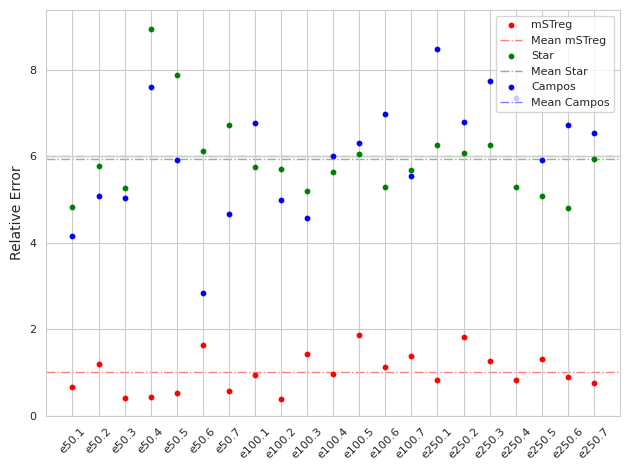

In [7]:
if save:
    folder='Figures/ORlibrary_Benchamark/'
    os.makedirs(folder,True)
s=10
fontsize=8
i=0
x=np.arange(0,len(costs_df))
c='rgbm'
f, ax = plt.subplots(1)
for i,label in enumerate(['mSTreg','Star','Campos']):
    y=np.array(100*(costs_df[label]/costs_GRASP_PR-1))
    # y=np.concatenate([y,[np.mean(y)]])
    plt.scatter(x, y, s=s, label=label, c=c[i])
    plt.axhline(y=np.mean(y), c=c[i], linewidth=1, alpha=0.5, linestyle='-.', zorder=0, label='Mean %s' % label)
# plt.xlabel('Problem instance')
plt.ylabel('Relative Error')
plt.xticks(x,[problem_idx for problem_idx in costs_df.index],
           fontsize=fontsize,rotation=45, ha='center')
plt.yticks( fontsize=fontsize)
ax.set_ylim(bottom=0)
plt.legend(fontsize=fontsize,loc='upper right')
plt.grid('off')
plt.tight_layout()
# plt.yscale('log')
if save:
    plt.savefig(folder+'MRCT_gap.png',dpi=200)
plt.show()